This is continuation of the Xarray module with some more advanced topics. This will show some ways Xarray can resample data to align different Datasets.

In [1]:
import numpy as np
import xarray as xr
import copy
import pandas as pd
import matplotlib.pyplot as plt

Create some data. data1 is integer type and data2 is float type just to show we can do that. data2 is also multiplied by 3.

In [2]:
num = 100
data1 = np.arange(0, num, dtype=int)
data2 = np.arange(0, num, dtype=float) * 3.

Make two additional arrays at half the size by stepping by 2.
Make the second additional array have some random noise on the data.

In [3]:
np.random.seed(42)
data3 = np.arange(0, num, 2, dtype=int)
data4 = (np.arange(0, num, 2, dtype=float) + np.random.uniform(low=-20, high=20, size=data3.size))

Create a datetime64 array with 1 minute time steps to match the size of data1 we created.

In [4]:
time1 = np.array('2019-11-01T00:00:00', dtype='datetime64[m]') + np.arange(data1.size)
time1 = time1.astype('datetime64[s]')  # Set precision to second.

Make time array to match data3 size over the same range (half the size of data1) and add random seconds from 0 to 30 to each time value

In [5]:
time3 = np.array('2019-11-01T00:00:00', dtype='datetime64[m]') + np.arange(data3.size)
time3 = time3.astype('datetime64[s]') + np.random.randint(-30, 30, time3.size)

In [6]:
print(data1.size, data3.size)
print(time1.size, time3.size)

100 50
100 50


Create Dataset 1 and 2

In [7]:
ds1 = xr.Dataset(data_vars={'data1': ('time', data1),
                            'data2': ('time', data2)},
                 coords={'time': ('time', time1)})

ds2 = xr.Dataset(data_vars={'data3': ('time', data3),
                            'data4': ('time', data4)},
                 coords={'time': ('time', time3)})

Using .loc will locate useing label based indexing along a dimension. Here we look for datetimes that fall within the range. The result is a new DataArray with fewer time samples.

In [8]:
ds = ds1['time'].loc['2019-11-01T00:05:01': '2019-11-01T00:15:00']
print(type(ds))
print(ds.values)

<class 'xarray.core.dataarray.DataArray'>
['2019-11-01T00:06:00.000000000' '2019-11-01T00:07:00.000000000'
 '2019-11-01T00:08:00.000000000' '2019-11-01T00:09:00.000000000'
 '2019-11-01T00:10:00.000000000' '2019-11-01T00:11:00.000000000'
 '2019-11-01T00:12:00.000000000' '2019-11-01T00:13:00.000000000'
 '2019-11-01T00:14:00.000000000' '2019-11-01T00:15:00.000000000']


Here we will make a copy of ds1 DataArray and save under a different name. This allows us to mess with it and not change the values in the Dataset. Note even though we are not explicity extracting time we can still perform operations on the time dimention.

In [9]:
da = copy.deepcopy(ds1['data1'])

Now we can use label based indexing to determine locations in the DataArray and change the values. We will use a time range to determine where to change the data values to a new value of -9999.

In [10]:
da.loc['2019-11-01T00:04:59': '2019-11-01T00:59:00'] = -9999
da.values

array([    0,     1,     2,     3,     4, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99])

Here we are going to match the times from Dataset 1 to Dataset 2. We use the select [.sel()] method to indicate where we want to select values from Dataset 1 using the times from Dataset 2. It will use the nearest value in time for matching. Notice the magic of how all the variables in the Dataset are selected. There are now 50 values.

In [11]:
ds1.sel(time=ds2['time'], method='nearest')

<xarray.Dataset>
Dimensions:  (time: 50)
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T00:49:00
Data variables:
    data1    (time) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    data2    (time) float64 0.0 3.0 6.0 9.0 12.0 ... 138.0 141.0 144.0 147.0

Or we can use .sel to perform a selection of a range across the full Dataset with the slice() function. Notice the magic of how all the variables in the Dataset are selected. The time dimension is reduced to size 11 from 100.

In [12]:
ds1.sel(time=slice('2019-11-01T00:04:59', '2019-11-01T00:15:00'))

<xarray.Dataset>
Dimensions:  (time: 11)
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01T00:05:00 ... 2019-11-01T00:15:00
Data variables:
    data1    (time) int64 5 6 7 8 9 10 11 12 13 14 15
    data2    (time) float64 15.0 18.0 21.0 24.0 27.0 ... 36.0 39.0 42.0 45.0

But what if we have a large gap and the nearest value falls outside a tolerable range. We can use .reindex method with a tolerance to indicate which values should be matched. The values that don't have a match are set to NaN. We need to use timedelta64() to set the tolerance value which includes a time unit. Remember we added a random 0 - 30 seconds to the time values. Notice the magic of how all the variables in the Dataset are updated. The size of the dataset is still 100 samples, just where a match could not be found it inserts NaN for data. Time step is still in the time coordinate.

If no values match within tollerence it will still make a new Dataset with all the time steps, but the data will all be set to NaN. Also notice how the integer arrays have been upcasted to float to allow setting the values to NaN.

In [13]:
ds2.reindex(time=ds1['time'], method='nearest', tolerance=np.timedelta64(20, 's'))

<xarray.Dataset>
Dimensions:  (time: 100)
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T01:39:00
Data variables:
    data3    (time) float64 0.0 2.0 4.0 6.0 nan 10.0 ... nan nan nan nan nan nan
    data4    (time) float64 -5.018 20.03 13.28 9.946 nan ... nan nan nan nan nan

Here we are merging two Datasets into one. We need to be a bit more careful about variable names. If the same variable name is used in both Datasets it will cause an error. First we use the inner join. Notice how few (if any) matches we find because of the random times. Times need to match exactly.

In [14]:
ds_merge = xr.merge((ds1, ds2), join='inner')
ds_merge.dims

Frozen({'time': 1})

Here we use the outer join, so it will be all the unique times of the combination of both Datasets. The length of the time dimenion is adjusted to correctly match the results with locations where a time exists but no data exists set to NaN. There is no tolerance. If the times are slightly off a new value is added. This is why this returned Dataset is larger than either of the input Datasets.

In [15]:
ds_merge = xr.merge((ds1, ds2), join='outer')
ds_merge.dims

Frozen({'time': 149})

We need to understand what is being matched. It is matching indexes and expanding the dimension to accomidate all the unique times from both Datasets.

Here we use .align() to get the two Datasets to match but not merge them into the same Dataset. The returned value is a tuple of two new Datasets.

In [16]:
ds_align = xr.align(ds1, ds2, join='inner')
ds_align = xr.align(ds1, ds2, join='outer')

In [17]:
print('inner:\n', ds_align[0].dims, ds_align[1].dims)
print('outer:\n', ds_align[0].dims, ds_align[1].dims)

inner:
 Frozen({'time': 149}) Frozen({'time': 149})
outer:
 Frozen({'time': 149}) Frozen({'time': 149})


We need to understand what is being matched. The result is an outer join so the times would need to match exactly to be used by both. If the times are slightly off both time steps are used and where there is no value a NaN is set.

In [18]:
print(ds_align[0]['data1'].values[:10])
print(ds_align[1]['data3'].values[:10])
print("result_align[0]['time'].size:", ds_align[0]['time'].size)
print("result_align[1]['time'].size:", ds_align[1]['time'].size)

[nan  0. nan  1.  2. nan  3. nan nan  4.]
[ 0. nan  2. nan nan  4. nan  6.  8. nan]
result_align[0]['time'].size: 149
result_align[1]['time'].size: 149


Let's see how the data differes with a difference and and print the mean value excluding NaN.

In [19]:
diff = ds_align[0]['data1'].values - ds_align[1]['data3'].values
np.nanmean(diff)

-7.0

## Block 2

Here we use pandas to make a time array with a 6 hour time step for four years.

In [20]:
pd_time = pd.date_range('2000-01-01', freq='6H', periods=365 * 4)

We will create a new Xarray Dataset with a range of numbers matching the number of time samples we created. The pandas time is used to initialize the xarray Dataset. Because Pandas and Xarray play well together it just works.

In [21]:
ds_pd_time = xr.Dataset({'data': ('time', np.arange(len(pd_time))), 'time': pd_time})

To create this same time step with Numpy we can do this. Both get the same result but Pandas may be more intutive?

In [22]:
np_time = np.array('2000-01-01', dtype='datetime64[h]') + np.arange(365 * 4) * 6
ds_np_time = xr.Dataset({'data': ('time', np.arange(len(np_time))), 'time': np_time})

In [23]:
(pd_time == np_time).all()

True

## Block 3

Lets start changing the values to meet our needs.

First the orginal data size

In [24]:
ds1['time'].size

100

Now let's calculate the mean for a day by grouping the data. This works for all time worded groups, hour, minute, year, month, ...

In [25]:
ds1_mean = ds1.groupby('time.day').mean()
ds1_mean

<xarray.Dataset>
Dimensions:  (day: 1)
Coordinates:
  * day      (day) int64 1
Data variables:
    data1    (day) float64 49.5
    data2    (day) float64 148.5

But what about a group that is not a standard group. Here we resample the data by an arbitray size and then make a of those groups.

In [26]:
ds1_mean = ds1.resample(time='8min').reduce(np.mean)
ds1_mean

<xarray.Dataset>
Dimensions:  (time: 13)
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T01:36:00
Data variables:
    data1    (time) float64 3.5 11.5 19.5 27.5 35.5 ... 67.5 75.5 83.5 91.5 97.5
    data2    (time) float64 10.5 34.5 58.5 82.5 ... 226.5 250.5 274.5 292.5

## Block 4

The best way to understand what is going on is to plot the data.

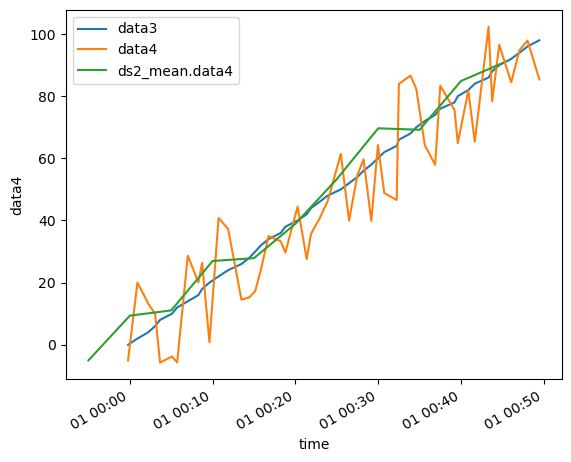

In [27]:
# Using methods attached to the Xarray Dataset we can call a matplotlib
# function to plot the data.
ds2['data3'].plot(label='data3')
ds2['data4'].plot(label='data4')

# We can add more plots to the graph including a mean.
# First we calcualte the resampled data mean in a new Dataset.
# The mean is a little strange because we are calculating the mean but the
# time location of the calculated value is placed at start of the bin time
# not the middle.
ds2_mean = ds2.resample(time='5min').reduce(np.mean)

# Then plot the new resampled mean data on the existing graph. Notice
# how we are making plot calls on two different Datasets. How this works
# I have no idea.
ds2_mean['data4'].plot(label="ds2_mean.data4")

# To lable the different lines we add a legend.
ignore = plt.legend()